# Naive Bayes on Amazon Reviews Dataset (Part II)


## Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:
**To find Precision, Recall, F1 Score, Confusion Matrix, Accuracy of 10-fold cross validation Naive Bayes on vectorized input data, for BoW and TF-IDF featurizations. TPR, TNR, FPR and FNR is calculated for both. The most frequent words in positive and negative class also needs to eb found out** 

## At a glance:
Random Sampling is done to reduce input data size and time based slicing to split into training and testing data. **The metrics obtained by applying 10-fold cross validation with Naive Bayes using BoW and tf-idf featurizations are compared to find optimal alpha for smoothing. **

The accuracy for different alpha values are plotted. The performance metrics with both featurizations are computed. **Most frequent words** in both classes are also enumerated. <br>

## Laplace Smoothing:

**Range of Alpha:** taken values ranging from ** 10^-6 to 10^3** 

To try out different values of alpha, **Geometric Progression is used as step function** in the above alpha range.<br><br>

# Preprocessed Data Loading

In [42]:
#loading libraries for NB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# import sklearn.metrics
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(3))
print(final.shape)

    index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ... 



# Random Sampling & Time Based Slicing

In [43]:
# To randomly sample the data and sort based on time before doing train/ test split.
# The slicing into train & test data will be done later in kfoldcv() function.

num_points = 200000

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# you can use random_state for reproducibility
sampled_final = final.sample(n=num_points, random_state=2)


#Sorting data according to Time in ascending order
sorted_final = sampled_final.sort_values('Time', axis=0, 
                ascending=True, inplace=False, kind='quicksort', na_position='last')

# fetching the outcome class 
y = sorted_final['Score'] # showing you two ways of indexing a pandas df
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(
    sorted_final, y, test_size=0.3, random_state=42)

(200000,)


# Custom Defined Functions

2 user defined functions are written to 

    a) K-fold Cross Validation & estimation of Optimal Alpha.

    b) Compute Performance Metrics of NB Classifier.
    
    c) Find Most Frequent Words.
        

## a) k-fold Cross Validation & Optimal Alpha Estimation

In [44]:
# split the data set into train and test. Do 10-fold cross validation
# For Binary BoW representation, Bernoulli NB is used.
# For count based BoW and tf-idf, Multinomial NB is used.

import numpy 
import math
import matplotlib.pyplot as plt 
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

def kfoldcv(X_train_vect, X_test_vect, 
                algo='MultinomialNB', toPlot = False, title_cf=''):

    # Time based slicing of data into train and test.  
#     num_train_data = int(split_ratio_train*X.shape[0])

#     X_train = X[0:num_train_data]
#     y_train = y[0:num_train_data]
#     X_test = X[num_train_data+1:]
#     y_test = y[num_train_data+1:]

    
    # generate gp sequence = ar^n
    a = 10**-6
    r = 2
    n = int(math.log(10**3/a, r)) # of times to do gp to reach 10^3
    alphas = [a * r**i for i in range(n)]

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for a in alphas:
        if (algo=='MultinomialNB'):
            nb = MultinomialNB(alpha=a)
        else:
            nb = BernoulliNB(alpha=a)
    
        scores = cross_val_score(nb, X_train_vect, y_train, cv=10)
        cv_scores.append(scores.mean())

    if (toPlot):
        plt.figure()
        plt.plot(alphas, cv_scores)
        plt.xlabel('Alpha Values')
        plt.ylabel('Accuracy Obtained')
        plt.title('Cross Validation Plot: Alpha vs Accuracy')
    
    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_alpha = alphas[MSE.index(min(MSE))]
    print('\nThe optimal value of alpha is %f.' % optimal_alpha)

    return compute_accuracy(X_train_vect, X_test_vect, 
                    alpha_val=optimal_alpha, algo=algo, title_cf=title_cf)

## b) Compute NB Classifier Performance Metrics

In [45]:
# ========================== NB with alpha = optimal_alpha ============================
#To compute the performance metrics of NB classifier 
# For Binary BoW representation, Bernoulli NB is used.
# For count based BoW and tf-idf, Multinomial NB is used.

import seaborn as sn
from sklearn.metrics import *

def compute_accuracy(X_train_vect, X_test_vect, 
                alpha_val, algo = 'BernoulliNB', title_cf = 'Confusion Matrix'):
    
    # Time based slicing of data into train and test.  
#     num_train_data = int(split_ratio_train*X.shape[0])

#     X_train = X[0:num_train_data]
#     y_train = y[0:num_train_data]
#     X_test = X[num_train_data+1:]
#     y_test = y[num_train_data+1:]

    # instantiate learning model k = optimal_k
    if (algo == 'BernoulliNB'):
        nb_optimal = BernoulliNB(alpha=alpha_val)
    else:
        nb_optimal = MultinomialNB(alpha=alpha_val)

    # fitting the model
    nb_optimal.fit(X_train_vect, y_train)


    # predict the response
    pred = nb_optimal.predict(X_test_vect)
    

    print(bold + '\n\nMetric Analysis of NB Classifier for Optimal Alpha' + end)
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nAccuracy = %f' % acc)
    
    precision = precision_score(y_test, pred, pos_label='positive') * 100
    print('\nPrecision = %f' % precision)
    
    recall = recall_score(y_test, pred, pos_label='positive') * 100
    print('\nRecall = %f' % recall)
    
    f1score = f1_score(y_test, pred, pos_label='positive') * 100
    print('\nF1 Score = %f' % f1score)
    
    confusion = confusion_matrix(y_test, pred, labels=["positive", "negative"])
    print(bold + "\n\nConfusion Matrix" + end)
    print(confusion)
    
    plt.figure()
    plt.title(title_cf)
    df_cm = pd.DataFrame(confusion, range(2), range(2))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d")# font size
    
    (tn, fp, fn, tp) = confusion.ravel()
    print("\nTrue Negatives = " + str(tn))
    print("True Positives = " + str(tp))
    print("False Negatives = " + str(fn))
    print("False Positives = " + str(fp))
    
    actual_positives = tp+fn
    actual_negatives = tn+fp
    print("\nTotal Actual Positives = " + str(actual_positives))
    print("Total Actual Negatives = " + str(actual_negatives))
    
    print("\nTrue Positive Rate(TPR) = " + str(round(tp/actual_positives, 2)))
    print("True Negative Rate(TNR) = " + str(round(tn/actual_negatives, 2)))
    print("False Positive Rate(FPR) = " + str(round(fp/actual_negatives, 2)))
    print("False Negative Rate(FNR) = " + str(round(fn/actual_positives, 2)))
    
    return nb_optimal.feature_log_prob_

## c) Find Most Frequent Words

In [46]:
# To find out the out positive and negative words based on feature log probabilities

# To get important words from feature_log_prob
# 1)Sort log prob values in ascending order and get the indices 
# 2)Get the ending 'n' indices to  find top n feature names (nwords) 
# having most occurences in class 1 and class 0
# 3)Use BOW.get_feature_name and find words corresponding to above 'n' indices


def find_top_words(vect, feature_log_probs, nwords):
    
    neg_class_prob_sorted = feature_log_probs[0, :].argsort()
    pos_class_prob_sorted = feature_log_probs[1, :].argsort()

    top_neg_words = np.take(vect.get_feature_names(), 
                            neg_class_prob_sorted[neg_class_prob_sorted.size-nwords:])
    top_pos_words = np.take(vect.get_feature_names(), 
                            pos_class_prob_sorted[pos_class_prob_sorted.size-nwords:])

    print(bold + "\n\nTop Negative Words: "+ end)
    for id, word in enumerate(top_neg_words):
        print("\t" + word + "\t Log Prob: " + str(
            round(feature_log_probs[
                0, neg_class_prob_sorted[neg_class_prob_sorted.size-nwords+id]], 2)))

    print(bold + "\nTop Positive Words: "+ end)
    for id, word in enumerate(top_pos_words):
        print("\t" + word + "\t Log Prob: " + str(
            round(feature_log_probs[
                1, pos_class_prob_sorted[pos_class_prob_sorted.size-nwords+id]], 2)))
    


# Bernoulli/ Multinomial NB on Binary BoW/ Count BoW

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

**For Binary BoW feature representation, Bernoulli NB is used as the value can take only 0 and 1. For count based BoW and tf-idf, Multinomial NB is used.** The variation of accuracy corresponding to varying values of alpha is plotted and the alpha with the highest accuracy is identified. Top words in both classes are found out using log probabilities.

(140000, 44920)


1) BoW with Multinomial NB

The optimal value of alpha is 2.097152.


Metric Analysis of NB Classifier for Optimal Alpha

Accuracy = 90.620000

Precision = 92.661611

Recall = 96.530137

F1 Score = 94.556323


Confusion Matrix
[[48879  1757]
 [ 3871  5493]]

True Negatives = 48879
True Positives = 5493
False Negatives = 3871
False Positives = 1757

Total Actual Positives = 9364
Total Actual Negatives = 50636

True Positive Rate(TPR) = 0.59
True Negative Rate(TNR) = 0.97
False Positive Rate(FPR) = 0.03
False Negative Rate(FNR) = 0.41

2) Binary BoW with Bernoulli NB

The optimal value of alpha is 0.008192.


Metric Analysis of NB Classifier for Optimal Alpha

Accuracy = 89.280000

Precision = 93.122488

Recall = 94.259025

F1 Score = 93.687310


Confusion Matrix
[[47729  2907]
 [ 3525  5839]]

True Negatives = 47729
True Positives = 5839
False Negatives = 3525
False Positives = 2907

Total Actual Positives = 9364
Total Actual Negatives = 50636

True Positive Rate(TPR) 

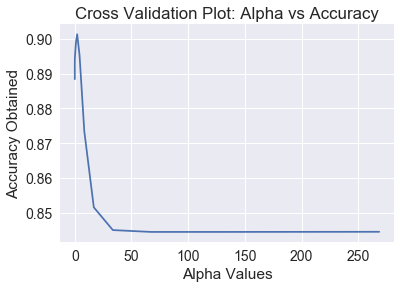

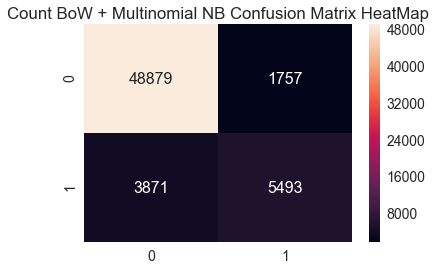

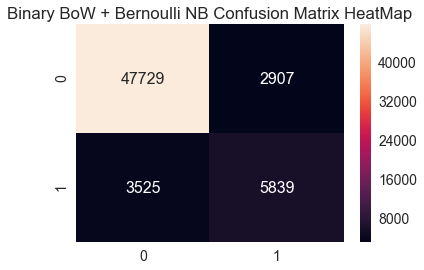

In [47]:
#BoW

# from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

# X_train, X_test, y_train, y_test

#Binary BoW
count_vect_bin = CountVectorizer(binary = True) #in scikit-learn
X_bin_train_vect = count_vect_bin.fit_transform(X_train['CleanedText'].values)
X_bin_train_vect.get_shape()

#BoW
count_vect = CountVectorizer() #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

#BoW Test
# count_vect = CountVectorizer() #in scikit-learn
X_test_bin_vect = count_vect_bin.transform(X_test['CleanedText'].values)
# X_test_bin_vect.get_shape()

#BoW Test
# count_vect = CountVectorizer() #in scikit-learn
X_test_vect = count_vect.transform(X_test['CleanedText'].values)
# X_test_vect.get_shape()

# print(X_test_bin_vect.get_shape())
print(X_train_vect.get_shape())

print(bold + "\n\n1) BoW with Multinomial NB"+ end)
feature_logprobs = kfoldcv(X_train_vect, X_test_vect, 
    algo = 'MultinomialNB', toPlot=True, 
        title_cf='Count BoW + Multinomial NB Confusion Matrix HeatMap')

# To run Binary BoW with Bernoulli NB
print(bold + "\n2) Binary BoW with Bernoulli NB" + end)
kfoldcv(X_bin_train_vect, X_test_bin_vect, algo="BernoulliNB", 
        title_cf='Binary BoW + Bernoulli NB Confusion Matrix HeatMap')

# To print 50 top words - positive and negative
find_top_words(count_vect, feature_logprobs, 50)

# Multinomial NB on tf-IDF Featurization

**Sparse matrix generated from tf-IDF ** is fed in to Multinomial Naive Bayes to find the optimal alpha value. Performance metrics of Multinomial NB with tf-idf featurization is found.

(140000, 44920)

 TF-IDF with Multinomial NB

The optimal value of alpha is 0.016384.


Metric Analysis of NB Classifier for Optimal Alpha

Accuracy = 87.821667

Precision = 87.863747

Recall = 99.283119

F1 Score = 93.225038


Confusion Matrix
[[50273   363]
 [ 6944  2420]]

True Negatives = 50273
True Positives = 2420
False Negatives = 6944
False Positives = 363

Total Actual Positives = 9364
Total Actual Negatives = 50636

True Positive Rate(TPR) = 0.26
True Negative Rate(TNR) = 0.99
False Positive Rate(FPR) = 0.01
False Negative Rate(FNR) = 0.74


Top Negative Words: 
	say	 Log Prob: -6.18
	wast	 Log Prob: -6.17
	water	 Log Prob: -6.16
	first	 Log Prob: -6.14
	got	 Log Prob: -6.14
	think	 Log Prob: -6.14
	better	 Log Prob: -6.14
	price	 Log Prob: -6.1
	item	 Log Prob: -6.1
	smell	 Log Prob: -6.1
	could	 Log Prob: -6.1
	make	 Log Prob: -6.09
	want	 Log Prob: -6.09
	thought	 Log Prob: -6.05
	receiv	 Log Prob: -6.02
	chocol	 Log Prob: -6.0
	didnt	 Log Prob: -6.0
	time	 Log Prob: -5.95

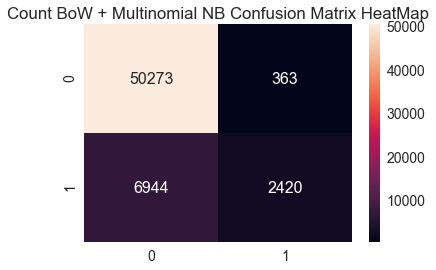

In [48]:
#TF-IDF
tf_idf_vect = TfidfVectorizer()
X_train_vect = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

#TF-IDF Test
# tf_idf_vect = TfidfVectorizer() #in scikit-learn
X_test_vect = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_vect.get_shape()

print(X_train_vect.get_shape())

print(bold + "\n TF-IDF with Multinomial NB" + end)
# To run brute & kd-tree knn & also time the code
feature_logprobs = kfoldcv(X_train_vect, X_test_vect, algo = 'MultinomialNB', 
                title_cf='Count BoW + Multinomial NB Confusion Matrix HeatMap')

# To print 50 top words - positive and negative
find_top_words(tf_idf_vect, feature_logprobs, 50)

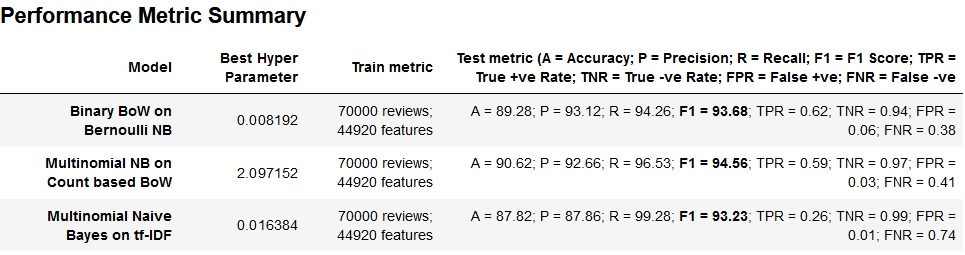

In [50]:
from IPython.display import Image
Image(filename='summary.jpg') 

## Observations



1) F1 Score of **"Count based BoW with Multinomial NB" is slightly higher than "Binary BoW with Bernoulli NB" method**. This indicates the **loss of information when the count vector is made binary.**

2) Accuracy of TF-IDF method is 2% less than that we got from BoW method.

3) TNR and Recall of **TF-IDF with Multinomial NB** method is as high as 99%. This indicates the **negative reviews are identified properly** with only 1% false positive rate.

4) If we need a system with a **prime requirement to correctly idenfity as many negative reviews** as possible, **then "Multinomial NB on tf-IDF"** should be used (as TNR = 0.99)

5) TPR of **TF-IDF with Multinomial NB** method is low (26%). 74% of **positive reviews are not identified** correctly (FPR = 0.74)

5) **TPR of "BoW with Multinomial NB" has the highest F1 Score, amongst all the three methods. Hence, Bag of Words featurization with multinomial Naive Bayes is the classifer of choice.**

6) Naive Bayes algorithm is based on Bayes’ theorem with a strong (naive) conditional independence assumption between the features. Hence, **working with w2v features which are completely dependent is not a good idea. Naive Bayes on W2V and tf-idf weighted W2v is not done for this reason.**